In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import sys
from natsort import natsorted

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Time points

In [3]:
#####Change to class?

#artifacts
first_art_begin = 0.081 
first_art_end = 0.0845 
second_art_begin = 0.131
second_art_end = 0.134

#time points of traces for analysis
end_cap = 0.02
first_stim_begin = 0.08
first_stim_end = 0.125
second_stim_begin = 0.136
second_stim_end = 0.175

#time points for finding NMDA decay time
end_tau_trace = 0.58
begin_NMDA_tau = 0.115
end_NMDA_tau = 0.5

#for finding tau of capacitance traces
begin_cap_curve = 0.00565
end_cap_curve = 0.011
begin_cap_baseline = 0.010
tau_threshold = 0.001

# Load experimental files and information

In [4]:
###Loop over all files in a folder to run automatically

#load excel file
wave_info = pd.read_excel('2016.10.26_Cell1.xlsx')
wave_info.head()

,waveNum,waveName,stimInt,notes
0,1,w7,40.0,noBic
1,2,w8,40.0,noBic
2,3,w9,40.0,noBic
3,4,w10,40.0,noBic
4,5,w11,40.0,noBic


In [5]:
#cell information
date = '2016.10.26'
cell_num = 1
age = 15

#Load csv
igor = pd.read_csv('igorForPython.csv', index_col = 0)

def select_waves(df):
    '''Takes the data frame of raw igor traces and: 
    1) indexes waves by wave names (info from excel file)
    2) removes traces with NaN values'''
    igor_waves = df.pivot(index = 'sec', columns = 'id', values = 'pA')
    waves = igor_waves.filter(wave_info['waveName'])
    waves = waves.dropna(axis = 0)
    return waves

#Reformat and select waves in waveInfo
all_waves = select_waves(igor)
all_waves.head()

id,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,0.948830,-3.059967,1.289867,-1.231331,-0.434429,2.303024,1.274933,0.613708,0.796894,1.317093,...,4.723364,1.359512,-1.399342,1.061974,1.475237,2.330578,-3.692544,-1.730488,-1.836338,-1.835079
0.00002,0.323860,-3.059967,-0.897526,-0.606361,-1.684368,2.615509,0.024994,0.301224,2.671803,2.567032,...,4.098394,1.359512,-1.711826,2.624397,0.850267,2.018093,-3.067575,-0.793034,-2.461308,-1.522594
0.00004,0.323860,-2.434998,0.039928,-0.293877,-1.996853,1.053085,0.649963,-0.636230,2.359318,2.567032,...,3.785910,1.359512,-1.711826,2.624397,2.412691,2.018093,-3.692544,-2.355457,-1.836338,-1.522594
0.00006,0.948830,-2.747482,0.039928,0.956062,-0.746914,0.740601,0.962448,0.613708,1.421864,1.942062,...,4.098394,1.671997,-1.086857,1.999428,0.850267,2.330578,-3.692544,-1.730488,-2.773792,-2.772533
0.00008,-0.301109,-1.185059,-1.210011,0.643578,-1.684368,2.303024,-0.287491,-0.011261,1.421864,3.504486,...,3.785910,1.047028,-1.711826,2.624397,1.162752,2.330578,-1.505151,-0.480549,-2.461308,-2.147564


# Calculating capacitance tau

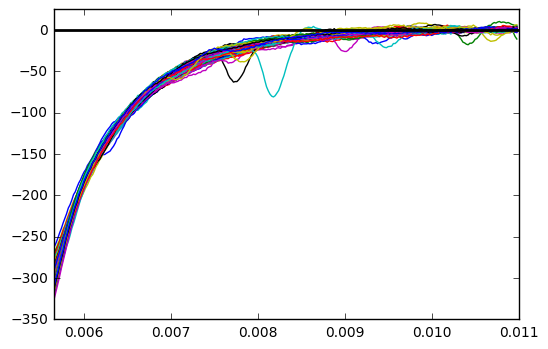

In [6]:
cap_curve = all_waves[begin_cap_curve:end_cap_curve]

def normalize_traces(df, begin, end):
    '''Normalizes traces to baseline'''
    baseline = df[begin:end]
    baseline = baseline.dropna(axis = 0)
    avg_baseline = baseline.mean()
    normalized_traces = df.subtract(avg_baseline)
    return normalized_traces

#normalize each cap trace to zero
#add 1.0e-10 so that can perform log transformation
normalized_cap = normalize_traces(cap_curve, begin_cap_baseline, end_cap_curve) + 1.0e-10

x = normalized_cap
fig, ax = plt.subplots()
ax.plot(x)
ax.axhline(y=0, color='k', linewidth=2)
ax.axvline(x=0, color='k')
ax.axis([begin_cap_curve, end_cap_curve, -350, 25])
plt.show();


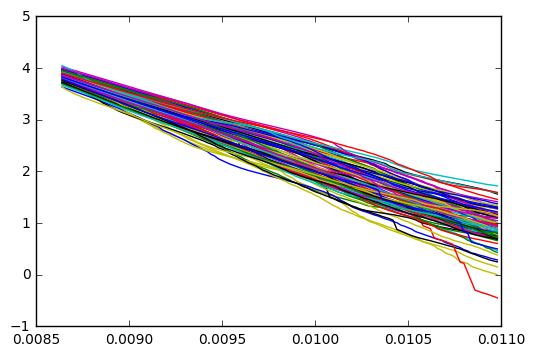

In [7]:
def smooth(df, window = 150):
    '''Uses rolling average window to smooth curve'''
    smoothed = df.rolling(window).mean()
    return smoothed

def log_to_fit(df, window = 150):
    '''Takes the log of a curve so that a linear regression can be fit and
    applies local function 'smooth' to smooth the curve.
    Returns log_curve, smoothed_curve'''
    log_curve = np.log(abs(df))
    smoothed_curve = smooth(log_curve, window)
    return log_curve, smoothed_curve

#Take log of amplitudes so can fit a linear model to cap traces
(_, smoothed_cap) = log_to_fit(normalized_cap)

plt.plot(smoothed_cap)
plt.show();

In [8]:
def calculate_tau(df):
    '''Fit a linear model to curve with log transformation to calculate decay times.
    Returns reg_model, coefs, decay_times'''
    #Fit a linear model
    traces_for_reg = df.reset_index()
    reg_model = {}
    for col_name in traces_for_reg.drop('sec', axis=1).columns:
        model = smf.ols(formula=col_name +' ~ sec', data=traces_for_reg)
        reg_model[col_name] = model.fit()

    #Pull out coefficients of each trace
    coefs = []
    ids = []
    for key in reg_model:
        id = key
        ids.append(id)
        coef = reg_model[key].params
        coefs.append(coef)

    coefs = pd.DataFrame(coefs, index = natsorted(ids))

    #Calculate all taus (small tau = fast decay)
    decay_times = abs(1 / coefs.drop('Intercept', 1))
    decay_times = decay_times.rename(columns = {'sec':'tau'})
    
    return reg_model, coefs, decay_times

(_, cap_coefs, cap_decay) = calculate_tau(smoothed_cap)

cap_coefs.head()
cap_decay.head()

#Examine parameters of individual waves
#reg_model['w7'].params

,Intercept,sec
w7,14.790453,-1261.590800
w8,14.744399,-1236.385745
w9,14.406656,-1195.063000
w10,14.200727,-1208.467227
w11,12.511447,-1051.389198


,tau
w7,0.000793
w8,0.000809
w9,0.000837
w10,0.000827
w11,0.000951


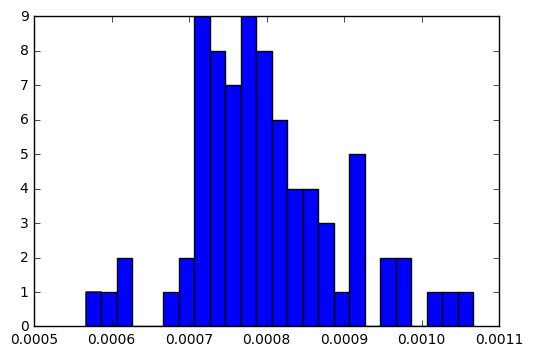

In [9]:
plt.hist(cap_decay['tau'], bins = 25)
plt.show();

# Process waves
* Remove stimulus artifacts
* Normalize traces
* Split waves into sections for analysis

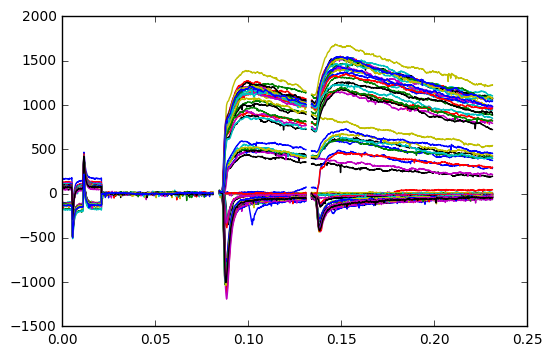

In [10]:
#!!!!change from all_waves to healthy_waves for final analysis

def remove_artifact(df, begin1, end1, begin2 = None, end2 = None):
    '''Removes stimulus artifact(s)'''
    df[begin1:end1] = np.nan
    df[begin2:end2] = np.nan
    return df

def process_waves(df, begin1 = first_art_begin, end1 = first_art_end, 
                  begin2 = second_art_begin, end2 = second_art_end, 
                  begin_norm = end_cap, end_norm = first_art_begin):
    '''Remove stimulus artifact(s), normalize traces to baseline
    begin1/end1: first stimulus artifact
    begin2/end2: second stimulus artifact
    begin_norm, end_norm: baseline'''
    df1 = remove_artifact(df, begin1, end1, begin2, end2)
    df2 = normalize_traces(df1, begin_norm, end_norm)
    return df2

#remove stimulus artifacts
processed_waves = process_waves(all_waves)

plt.plot(processed_waves)
plt.show();

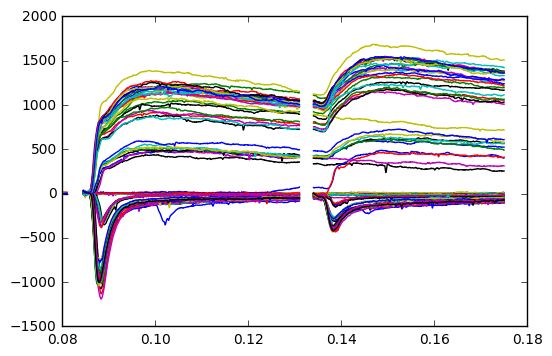

In [11]:
def divide_into_sections(df, begin1 = first_stim_begin, end1 = first_stim_end, 
                         begin2 = second_stim_begin, end2 = second_stim_end):
    '''Divide waves into sections for analysis'''
    first = df[begin1:end1]
    second = df[begin2:end2]
    both = df[begin1:end2]
    return first, second, both

#divide waves into sections for analysis
first_stim, second_stim, both_stim = divide_into_sections(processed_waves)

plt.plot(both_stim)
plt.show();

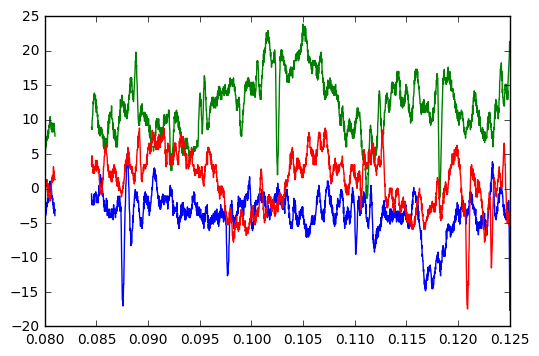

In [12]:
def plot_indiv_waves(df, *args):
    '''Plots individual waves by wave id for basic visualization'''
    to_select = []
    for id in args:
        wave = wave_info[wave_info['waveName'].values == id]['waveName']
        to_select.append(wave)
    selection = [item for sublist in to_select for item in sublist]
    return plt.plot(df[selection])

plot_indiv_waves(first_stim, 'w35', 'w42', 'w44')
plt.show();

# Capacitance tau and current amplitudes
It is known that decreased capacitance implies increased resistance, which then decreases current flow. Therefore a slow capacitance decay time affects current responses (particularly NMDA responses) of a neuron, decreasing current amplitudes at a fixed stimulation intensity compared to a faster decay time. The question is then, what is the threshold for capacitance decay times where the slow decay begins affecting the current amplitude?

In [13]:
def filter_waves(df, *args, keep = True):
    '''Filter waves by information in notes column of wave_info data frame;
    keep is true by default'''
    notes = wave_info.loc[:, ['waveName', 'notes']]
    waves_index = []
    for note in args:
        #selects wave ids (waveName) that matches args
        waves = list(notes[(notes['notes'] == note)]['waveName'])
        waves_index.append(waves)
        
    if len(waves) == 0:
        print(note + ' not in wave_info')
        
    final_waves = [item for sublist in waves_index for item in sublist]
    
    if keep == True:
        df = df[final_waves]
    elif keep == False: 
        df = df.drop(final_waves, 1)
    
    return df

def calculate_maximals(df, second):
    '''Calculate maximals. Because of noise, amplitude of failure traces must be averaged.
    Second = False, finds failures in first stim period.
    Returns df_of_maximals, failures_amp.index'''
    df_of_maximals = pd.DataFrame(abs(df).max(), columns = ['maximals'])
    
    #Find maximals of failures in first stimulation period
    if second == False:
        failures = filter_waves(df, 'x', '2nd')
    
    #Find maximals of failures in second stimulation period
    elif second == True:
        failures = filter_waves(df, 'x')
    
    failures_amp = pd.DataFrame(failures.mean(), columns = ['maximals'])
    
    #Replace values in df_of_maximals with values in failures_amp
    df_of_maximals.ix[failures_amp.index] = abs(failures_amp)
    
    return df_of_maximals, failures_amp.index

max_amplitudes, fail_index = calculate_maximals(first_stim, second = False)
max_amplitudes.ix[fail_index]

,maximals
id,
w29,0.442229
w30,7.192909
w31,1.330590
w32,0.814606
w35,3.625050
w36,6.079069
w37,2.812684
w38,2.515626
w39,1.909543


In [14]:
stim_int = wave_info.drop(wave_info.columns[[0, 3]], axis = 1)
stim_int = stim_int.set_index('waveName')
stim_int.columns = ['stim_int']

cap_vs_max = pd.concat([cap_decay, max_amplitudes, stim_int], axis = 1)

#change to take any fxn?
def log_column(df, col_name):
    '''Takes the log of a column of a df by column name and creates new column'''
    df['log_' + col_name] = df[col_name].apply(np.log)
    return df

cap_vs_max = log_column(cap_vs_max, col_name = 'stim_int')

cap_vs_max.head()

,tau,maximals,stim_int,log_stim_int
w7,0.000793,784.708995,40.0,3.688879
w8,0.000809,1051.080566,40.0,3.688879
w9,0.000837,988.026405,40.0,3.688879
w10,0.000827,1148.410750,40.0,3.688879
w11,0.000951,975.808969,40.0,3.688879


In [15]:
def split_rows_AN(df):
    '''Split df where rows are waves into AMPA/NMDA,
    returns AMPA and NMDA'''
    AMPA = df[::2]
    NMDA = df[1::2]
    return AMPA, NMDA

#Fxn to create df for bokeh plotting
def df_for_bokeh(df, *args):
    '''Create a df for bokeh plotting. AMPA and NMDA dfs are individually split, 
    then re-merged with the same index for linked plotting.
    Returns individual AMPA/NMDA dfs and merged df.'''
    dfA, dfN = split_rows_AN(df)
    df_AN = dfA.rename(columns = lambda x: x + '_A')
    for col in args:
        df_AN[col + '_N'] = list(dfN[col])
    return dfA, dfN, df_AN

#create df where AMPA/NMDA waves have the same index for bokeh plotting
cap_vs_max_A, cap_vs_max_N, cap_vs_max_AN = df_for_bokeh(cap_vs_max, 'tau', 'maximals')

cap_vs_max_AN.head()

,tau_A,maximals_A,stim_int_A,log_stim_int_A,tau_N,maximals_N
w7,0.000793,784.708995,40.0,3.688879,0.000809,1051.080566
w9,0.000837,988.026405,40.0,3.688879,0.000827,1148.410750
w11,0.000951,975.808969,40.0,3.688879,0.000799,1166.296313
w13,0.000810,1074.811906,40.0,3.688879,0.001041,1188.434037
w15,0.000726,1015.781239,40.0,3.688879,0.000710,1148.466860


In [16]:
#sanity check
cap_vs_max_A.min()
cap_vs_max_A.max()
cap_vs_max_N.min()
cap_vs_max_N.max()

tau              0.000673
maximals         0.442229
stim_int        10.000000
log_stim_int     2.302585
dtype: float64

tau                0.001020
maximals        1189.726536
stim_int        1000.000000
log_stim_int       6.907755
dtype: float64

tau              0.000567
maximals         0.814606
stim_int        10.000000
log_stim_int     2.302585
dtype: float64

tau                0.001067
maximals        1389.530604
stim_int        1000.000000
log_stim_int       6.907755
dtype: float64

In [47]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import LogColorMapper, LogTicker, ColorBar, HoverTool, LabelSet
from bokeh.models.tools import PanTool, BoxZoomTool, BoxSelectTool, ResetTool, LassoSelectTool, SaveTool
from bokeh.layouts import row, column

source = ColumnDataSource(cap_vs_max_AN)

#color points by stim_int on a log scale
color_mapper = LogColorMapper(palette = 'Viridis256', low = 5, high = 1000)
tools = 'box_select, pan, box_zoom, lasso_select, reset, save'

p1 = figure(x_axis_label = 'tau (sec)', y_axis_label = 'amplitude (pA)',\
           title = 'AMPA amplitude vs. capacitance decay', tools = tools)
    
p1.circle(x = 'tau_A', y = 'maximals_A', source = source,\
          color = dict(field = 'stim_int_A', transform = color_mapper),\
          size = 4.5, alpha = 0.8)

p2 = figure(x_axis_label = 'tau (sec)', title = 'NMDA amplitude vs. capacitance decay', tools = tools)
    
p2.circle(x = 'tau_N', y = 'maximals_N', source = source,\
          color = dict(field = 'stim_int_A', transform = color_mapper),\
          size = 4.5, alpha = 0.8)

color_bar = ColorBar(color_mapper = color_mapper, ticker = LogTicker(base = 100),\
                     label_standoff = 8, border_line_color = None, location = (0,0))
p2.add_layout(color_bar, 'right')
    
#labels = LabelSet(x = 'capacitance tau', y = 'maximals', text = 'index', y_offset = 3,
#              text_font_size = "8pt", text_color = "#555555",
#              source = source, text_align = 'center')
#p.add_layout(labels)
    
hover1 = HoverTool(tooltips = [
        ('ID', '@index'),
        ('Tau', '@tau_A'),
        ('Amplitude', '@maximals_A'),
        ('Stimulus intensity', '@stim_int_A')
    ])
p1.add_tools(hover1)

hover2 = HoverTool(tooltips = [
        ('ID', '@index'),
        ('Tau', '@tau_N'),
        ('Amplitude', '@maximals_N'),
        ('Stimulus intensity', '@stim_int_A')
    ])
p2.add_tools(hover2)
    

layout = row(p1, p2)

output_notebook();
show(layout);

Loading BokehJS ...

# AMPA tau
In addition to decreasing current amplitudes, another concern regarding large capacitance tau is it could lead to increased AMPA tau due to worsening access. Therefore, AMPA tau must also be calculated. To do so:
* Isolate AMPA waves following first stimulus
* Remove stimulus artifact
* Performing above step allows automatic identification of peak of AMPA trace
* Fit a curve from peak of AMPA trace to end of stimulation

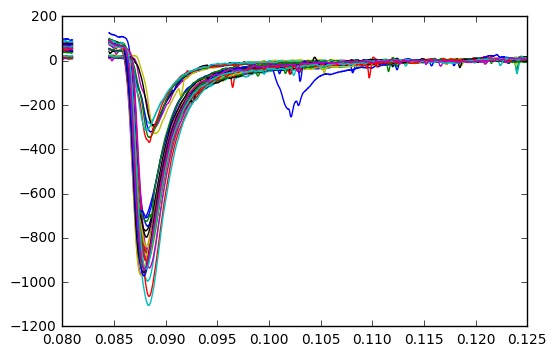

In [18]:
#remove failures (traces that did not respond during first stimulation)
#as don't need to calculate AMPA decay for failures
success_traces = filter_waves(all_waves, 'x', '2nd', keep = False)

def split_columns_AN(df):
    '''Takes a df where the columns are waves
    and splits/returns separate AMPA and NMDA dfs'''
    AMPA = df[df.columns[::2]]
    NMDA = df[df.columns[1::2]]
    return AMPA, NMDA

#select only AMPA waves in first stim period
success_traces, _ = split_columns_AN(success_traces)
success_traces, _, _ = divide_into_sections(success_traces)

#process waves; use different baseline to normalize traces
success_traces = process_waves(success_traces, begin_norm = 0.11, end_norm = first_stim_end)

plt.plot(success_traces)
plt.show();

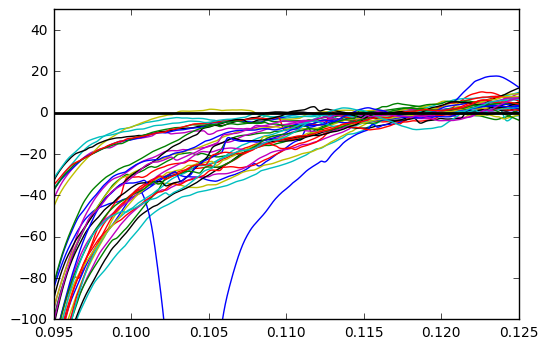

In [19]:
p = smooth(success_traces)
fig, ax = plt.subplots()
ax.plot(p)
ax.axhline(y=0, color='k', linewidth=2)
ax.axvline(x=0, color='k')
ax.axis([0.095, 0.125, -100, 50])
plt.show();

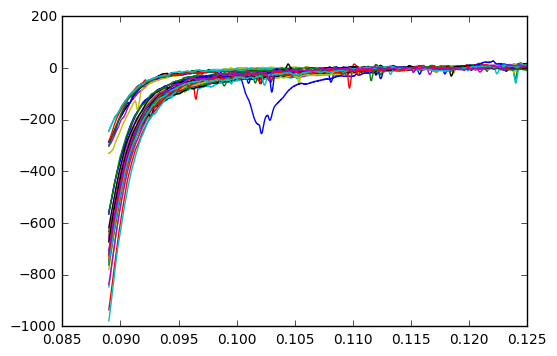

In [20]:
#suppresses error message
pd.options.mode.chained_assignment = None 

#align peak of AMPA trace
aligned_traces = success_traces
for c in aligned_traces.columns:
    min_index = success_traces.idxmin()
    aligned_traces.loc[aligned_traces[c].index < min_index[c]] = np.nan 

plt.plot(aligned_traces)
plt.show();

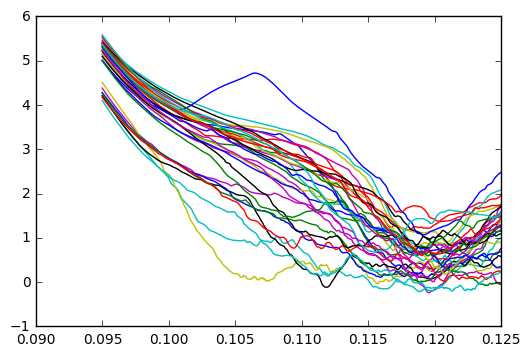

In [21]:
(_, smoothed_AMPA) = log_to_fit(aligned_traces, window = 300)
plt.plot(smoothed_AMPA)
plt.show();

# What is the threshold for capacitance decay?

Are features (capacitance tau, maximals, stim_int, AMPA tau) correlated?

In [22]:
cap_vs_max_A.corr()

,tau,maximals,stim_int,log_stim_int
tau,1.000000,-0.045483,0.053012,0.032728
maximals,-0.045483,1.000000,0.356579,0.647333
stim_int,0.053012,0.356579,1.000000,0.909945
log_stim_int,0.032728,0.647333,0.909945,1.000000


In [23]:
cap_vs_max_N.corr()

,tau,maximals,stim_int,log_stim_int
tau,1.000000,0.046646,-0.142123,-0.124095
maximals,0.046646,1.000000,0.426797,0.710447
stim_int,-0.142123,0.426797,1.000000,0.909945
log_stim_int,-0.124095,0.710447,0.909945,1.000000


There seems to exist only weak overall correlation between capacitance tau and the other features. 
Use anomaly detection (kNN, random forest?) to detect rare event, i.e., an unsuitable trace. Assumption is that obviously unhealthy cells are discarded during recording and/or prior to analysis.

In [24]:
from sklearn import preprocessing

def scale_columns(series):
    '''Uses sklearn's scale function to standardize all data in a df
    column (a pandas Series object) to zero mean and unit variance'''
    scaled = preprocessing.scale(np.array(series))
    return scaled

def recombine_AN(dfA, dfN):
    '''Recombines individual AMPA and NMDA dfs
    back into one df in an ordered manner'''
    temp = list(zip(dfA, dfN))
    recombined = [item for sublist in temp for item in sublist]
    return recombined

cap_vs_max['scaled cap tau'] = scale_columns(cap_vs_max['tau'])
scaled_AMPA = scale_columns(cap_vs_max.maximals[::2])
scaled_NMDA = scale_columns(cap_vs_max.maximals[1::2])
cap_vs_max['scaled maximals'] = recombine_AN(scaled_AMPA, scaled_NMDA)

cap_vs_max.head()

,tau,maximals,stim_int,log_stim_int,scaled cap tau,scaled maximals
w7,0.000793,784.708995,40.0,3.688879,-0.067496,0.249086
w8,0.000809,1051.080566,40.0,3.688879,0.101645,0.549788
w9,0.000837,988.026405,40.0,3.688879,0.394383,0.787093
w10,0.000827,1148.410750,40.0,3.688879,0.297231,0.763357
w11,0.000951,975.808969,40.0,3.688879,1.591283,0.754764


In [25]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(capVSmax['capTauScaled'], capVSmax['maxScaled'], capVSmax['logStimInt']);
#plt.show();

# Filtering waves 

Unhealthy waves (or waves unsuitable for analysis) must be removed prior to calculations. For analysis AMPA and NMDA waves must be paired, i.e., an AMPA trace must have a matched NMDA trace and vice versa. 

Therefore, to remove unhealthy waves and their corresponding partners:
* Identify unhealthy waves by capacitance decay time, AMPA decay and leak currents
* Split waves into AMPA and NMDA waves
* Remove unhealthy waves by index in individual AMPA/NMDA dfs (indices are the same in the individual dfs)
* Create a list of ids of healthy cells and filter all_waves on list

In [26]:
#list below for test purposes only; should be identified automatically
unhealthy = [1,3,5,7]

def remove_unhealthy(df, unhealthyIndices):    
    '''Removes unsuitable/unhealthy traces by index'''
    AMPA, NMDA = split_columns_AN(df)
    healthy_A = AMPA.drop(AMPA.columns[unhealthyIndices], axis = 1)
    healthy_N = NMDA.drop(NMDA.columns[unhealthyIndices], axis = 1)
    healthy_waves = df.filter(recombine_AN(healthy_A, healthy_N))
    return healthy_waves

healthy_waves = remove_unhealthy(processed_waves, unhealthy)
healthy_waves.head()

id,w7,w8,w11,w12,w15,w16,w19,w20,w23,w24,...,w75,w76,w77,w78,w79,w80,w81,w82,w83,w84
sec,,,,,,,,,,,,,,,,,,,,,
0.00000,168.994412,-174.172028,117.575205,-134.265165,106.351470,-124.908552,96.858381,-127.548280,99.912748,-127.347671,...,76.092184,-116.011548,71.067940,-115.329512,71.286377,-122.708868,65.309208,-127.143488,67.573234,-134.802328
0.00002,168.369442,-174.172028,116.325266,-133.952680,108.226379,-123.658613,96.858381,-128.798219,99.600263,-127.660156,...,75.467215,-116.011548,70.755455,-113.767088,70.661408,-123.021353,65.934177,-126.206034,66.948264,-134.489843
0.00004,168.369442,-173.547058,116.012781,-135.515104,107.913894,-123.658613,95.920927,-126.923310,98.975294,-125.785248,...,75.154730,-116.011548,70.755455,-113.767088,72.223832,-123.021353,65.309208,-127.768457,67.573234,-134.489843
0.00006,168.994412,-173.859543,117.262720,-135.827589,106.976440,-124.283583,95.920927,-128.173249,99.600263,-124.847793,...,75.467215,-115.699063,71.380425,-114.392058,70.661408,-122.708868,65.309208,-127.143488,66.635779,-135.739782
0.00008,167.744473,-172.297119,116.325266,-134.265165,106.976440,-122.721159,94.983473,-128.485734,99.600263,-123.285370,...,75.154730,-116.324033,70.755455,-113.767088,70.973893,-122.708868,67.496601,-125.893549,66.948264,-135.114812


In [53]:
#remove waves without bicuculline, 'test' waves, NMDA tau wave
#waves_to_analyze = filter_waves(healthy_waves, 'noBic', 'test', 'NMDA tau', keep = False)
waves_to_analyze = filter_waves(processed_waves, 'noBic', 'test', 'NMDA tau', keep = False) #change

first, second, both = divide_into_sections(waves_to_analyze)

to_index = pd.Series(waves_to_analyze.columns)
vs_stim_int = cap_vs_max.drop(['tau', 'scaled cap tau', 'scaled maximals'], axis = 1)
vs_stim_int = vs_stim_int.filter(to_index, axis = 'index')

#calculate paired pulse ratio (PPR) = second response/first response
vs_stim_int['second_max'], _ = calculate_maximals(second, second = True)
vs_stim_int['PPR'] = vs_stim_int['second_max'] / vs_stim_int['maximals']
vs_stim_int = log_column(vs_stim_int, 'PPR')
vs_stim_int.head()

,maximals,stim_int,log_stim_int,second_max,PPR,log_PPR
w17,974.532377,40.0,3.688879,380.498838,0.390442,-0.940475
w18,1137.747316,40.0,3.688879,1429.608034,1.256525,0.228350
w19,845.283140,100.0,4.605170,295.309996,0.349362,-1.051646
w20,1021.458083,100.0,4.605170,1263.321242,1.236782,0.212513
w21,847.582785,1000.0,6.907755,296.984671,0.350390,-1.048708


In [76]:
#Separate out AMPA and NMDA waves for plotting
vs_stim_int_A, vs_stim_int_N, vs_stim_int_AN = df_for_bokeh(vs_stim_int, 'maximals', 'PPR', 'log_PPR', 'second_max')

#Calculate AMPA/NMDA ratio
vs_stim_int_AN['AN_ratio'] = vs_stim_int_AN['maximals_A'] / vs_stim_int_AN['maximals_N']
vs_stim_int_AN = log_column(vs_stim_int_AN, 'AN_ratio')

vs_stim_int_AN['rank'] = list(range(len(vs_stim_int_AN)))

vs_stim_int_AN.head()

,maximals_A,stim_int_A,log_stim_int_A,second_max_A,PPR_A,log_PPR_A,maximals_N,PPR_N,log_PPR_N,second_max_N,AN_ratio,log_AN_ratio,rank
w17,974.532377,40.0,3.688879,380.498838,0.390442,-0.940475,1137.747316,1.256525,0.228350,1429.608034,0.856546,-0.154848,0
w19,845.283140,100.0,4.605170,295.309996,0.349362,-1.051646,1021.458083,1.236782,0.212513,1263.321242,0.827526,-0.189315,1
w21,847.582785,1000.0,6.907755,296.984671,0.350390,-1.048708,1242.732626,1.182301,0.167463,1469.284018,0.682031,-0.382679,2
w23,935.349143,1000.0,6.907755,281.943594,0.301431,-1.199213,1136.965710,1.084651,0.081258,1233.210949,0.822671,-0.195198,3
w27,297.101594,15.0,2.708050,130.547211,0.439403,-0.822339,487.054181,1.233536,0.209884,600.798626,0.609997,-0.494301,4


# Plotting amplitude, PPR, A/N vs. stimulus intensity

In [86]:
from bokeh.models import LinearColorMapper

#Make bokeh plot of maximals, PPR, AMPA/NMDA ratio
source = ColumnDataSource(vs_stim_int_AN)
length = len(vs_stim_int_AN)
color_mapper = LinearColorMapper(palette = 'Viridis256', low = 0, high = length)
tools = 'box_select, pan, box_zoom, lasso_select, reset, save'
label = 'stimulus intensity (log)'
field = 'rank'
x = 'log_stim_int_A'
color_bar = ColorBar(color_mapper = color_mapper, ticker = LogTicker(base = 100),
                     label_standoff = 8, border_line_color = None, location = (0,0))

#AMPA maximals
p_max_A = figure(x_axis_label = label, y_axis_label = 'amplitude (pA)',
           title = 'AMPA amplitude vs. ' + label, tools = tools)

p_max_A.circle(x = x, y = 'maximals_A', source = source,
         color = dict(field = field, transform = color_mapper), size = 4.5, alpha = 0.8)

hover_max_A = HoverTool(tooltips = [
        ('ID', '@index'),
        ('Amplitude', '@maximals_A'),
        ('Stimulus intensity', '@stim_int_A'),
        ('Wave # of ' + str(length - 1), '@rank')
    ])
p_max_A.add_tools(hover_max_A)

#NMDA maximals
p_max_N = figure(x_axis_label = label,
           title = 'NMDA amplitude vs. ' + label, tools = tools)

p_max_N.circle(x = x, y = 'maximals_N', source = source,
         color = dict(field = field, transform = color_mapper), size = 4.5, alpha = 0.8)

hover_max_N = HoverTool(tooltips = [
        ('ID', '@index'),
        ('Amplitude', '@maximals_N'),
        ('Stimulus intensity', '@stim_int_A'),
        ('Wave # of ' + str(length - 1), '@rank')
    ])
p_max_N.add_tools(hover_max_N)

row_max = row(p_max_A, p_max_N)

#AMPA PPR
p_ppr_A = figure(x_axis_label = label, y_axis_label = 'PPR (log)',
           title = 'AMPA PPR (log) vs. ' + label, tools = tools)

p_ppr_A.circle(x = x, y = 'log_PPR_A', source = source,
         color = dict(field = field, transform = color_mapper), size = 4.5, alpha = 0.8)

hover_ppr_A = HoverTool(tooltips = [
        ('ID', '@index'),
        ('PPR', '@PPR_A'),
        ('Stimulus intensity', '@stim_int_A'),
        ('Wave # of ' + str(length - 1), '@rank')
    ])
p_ppr_A.add_tools(hover_ppr_A)

#NMDA PPR
p_ppr_N = figure(x_axis_label = label,
           title = 'NMDA PPR (log) vs. ' + label, tools = tools)

p_ppr_N.circle(x = x, y = 'log_PPR_N', source = source,
         color = dict(field = field, transform = color_mapper), size = 4.5, alpha = 0.8)

hover_ppr_N = HoverTool(tooltips = [
        ('ID', '@index'),
        ('PPR', '@PPR_N'),
        ('Stimulus intensity', '@stim_int_A'),
        ('Wave # of ' + str(length - 1), '@rank')
    ])
p_ppr_N.add_tools(hover_ppr_N)

row_PPR = row(p_ppr_A, p_ppr_N)

#AMPA/NMDA
p_AN = figure(x_axis_label = label, y_axis_label = 'AMPA/NMDA (log)',
           title = 'AMPA/NMDA (log) vs. ' + label, tools = tools)

p_AN.circle(x = x, y = 'log_AN_ratio', source = source,
         color = dict(field = field, transform = color_mapper), size = 4.5, alpha = 0.8)

hover_AN = HoverTool(tooltips = [
        ('ID', '@index'),
        ('AMPA/NMDA', '@AN_ratio'),
        ('Stimulus intensity', '@stim_int_A'),
        ('Wave # of ' + str(length - 1), '@rank')
    ])
p_AN.add_tools(hover_AN)
p_AN.add_layout(color_bar, 'right')

layout = column(row_max, row_PPR, p_AN)

output_notebook();
show(layout);

Loading BokehJS ...

In [32]:
#Rank AMPA and NMDA amplitudes from smallest to largest
#Do ranks correspond between A and N?
#Stimulus intensity is not strictly increasing; take previous intensity into account, 
#i.e., relative difference bw previous and current stim_int



# Calculate NMDA tau
Decay time of NMDA currents change over development

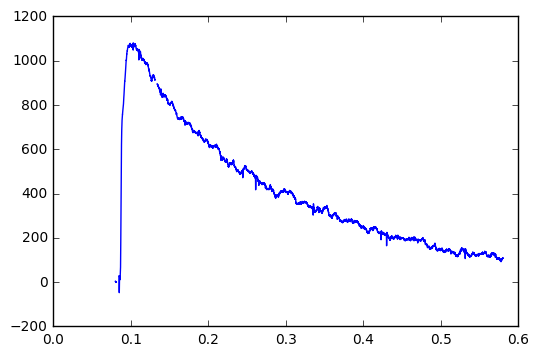

In [35]:
#NMDA tau wave is longer than other traces; must be selected separately
def find_NMDA_tau_wave(df):
    '''Selects NMDA tau trace'''
    waves = df.pivot(index = 'sec', columns = 'id', values = 'pA')
    NMDA_tau = filter_waves(waves, 'NMDA tau')
    return NMDA_tau

NMDA_tau_wave = find_NMDA_tau_wave(igor)
NMDA_tau_wave = process_waves(NMDA_tau_wave) #does not correctly get rid of second stim artifact for NMDA tau wave

plt.plot(NMDA_tau_wave[first_stim_begin:end_tau_trace])
plt.show();

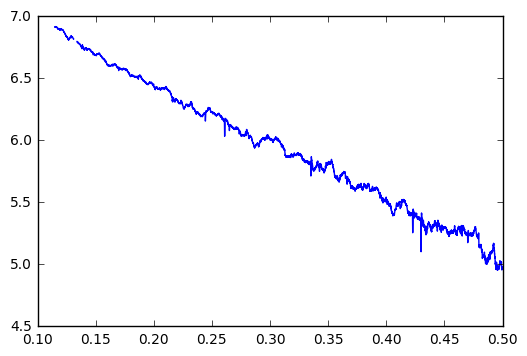

In [36]:
NMDA_tau_fit, _ = log_to_fit(NMDA_tau_wave[begin_NMDA_tau:end_NMDA_tau])

plt.plot(NMDA_tau_fit)
plt.show();

In [37]:
#Specify reg_model if want to determine whether linear fit is a good model
_, NMDA_tau_coef, NMDA_tau = calculate_tau(NMDA_tau_fit)
NMDA_tau = float(NMDA_tau['tau'])
NMDA_tau

0.2140941018985893